## 1. Setup and Imports - Emmanuel

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import pickle
import os
warnings.filterwarnings('ignore')

# NLP and preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Deep Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

## 2. Data Loading and Initial Exploration

In [2]:
# Load datasets (header handled automatically)
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# Rename 'Class Index' to 'Class' for convenience
train_df = train_df.rename(columns={'Class Index': 'Class'})
test_df = test_df.rename(columns={'Class Index': 'Class'})

In [3]:
print("Dataset loaded successfully!")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print("\nFirst few rows:")
train_df.head()

Dataset loaded successfully!
Training samples: 120000
Testing samples: 7600

First few rows:


,Class,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## 3. Exploratory Data Analysis (EDA)

In [4]:
# Class mapping
class_names = {
    1: 'World',
    2: 'Sports',
    3: 'Business',
    4: 'Sci/Tech'
}

# Add class names
train_df['Class_Name'] = train_df['Class'].map(class_names)
test_df['Class_Name'] = test_df['Class'].map(class_names)

# Combine Title and Description for richer text representation
train_df['Text'] = train_df['Title'] + ' ' + train_df['Description']
test_df['Text'] = test_df['Title'] + ' ' + test_df['Description']

print("\nDataset info:")
print(train_df.info())
print("\nClass distribution:")
print(train_df['Class_Name'].value_counts())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class        120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
 3   Class_Name   120000 non-null  object
 4   Text         120000 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.6+ MB
None

Class distribution:
Class_Name
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


In [5]:
# Visualization 4: Sample texts by class
print("\n=== Sample Texts by Class ===")
for class_name in class_names.values():
    print(f"\n{class_name.upper()}:")
    sample = train_df[train_df['Class_Name'] == class_name]['Text'].iloc[0]
    print(f"{sample[:200]}...")


=== Sample Texts by Class ===

WORLD:
Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing P...

SPORTS:
Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American tea...

BUSINESS:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....

SCI/TECH:
'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\on Tuesday among the guys at the office? EA Sports would like\to think it was because "Madden NFL 20...


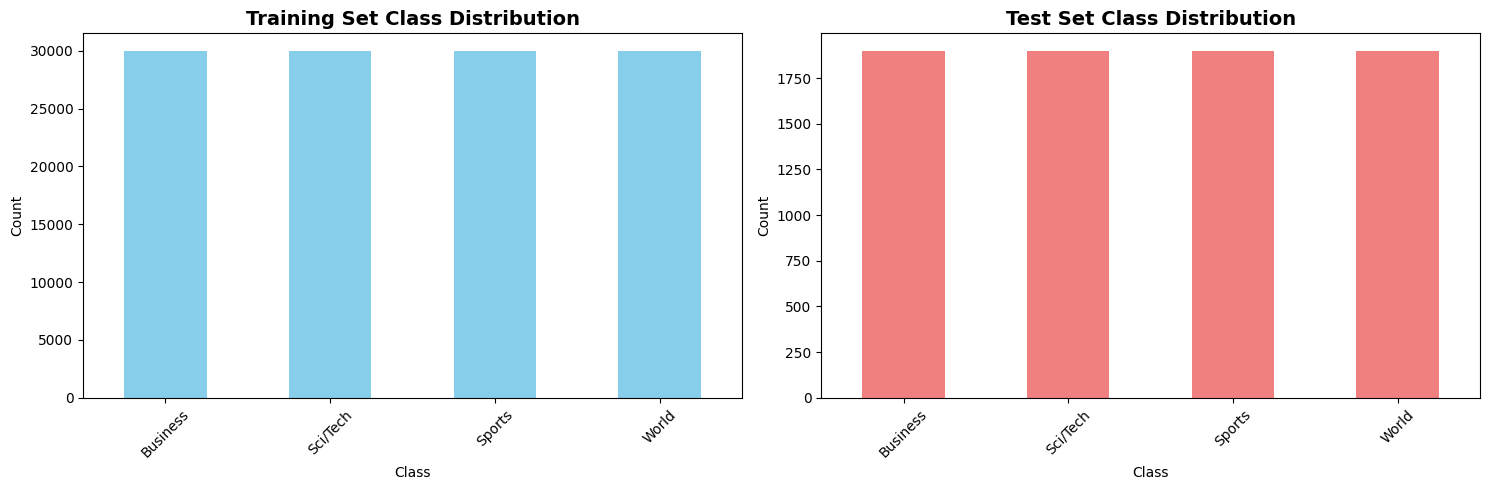

Class distribution is balanced across both training and test sets.


In [6]:
# Visualization 1: Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
train_df['Class_Name'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Test set distribution
test_df['Class_Name'].value_counts().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Class distribution is balanced across both training and test sets.")

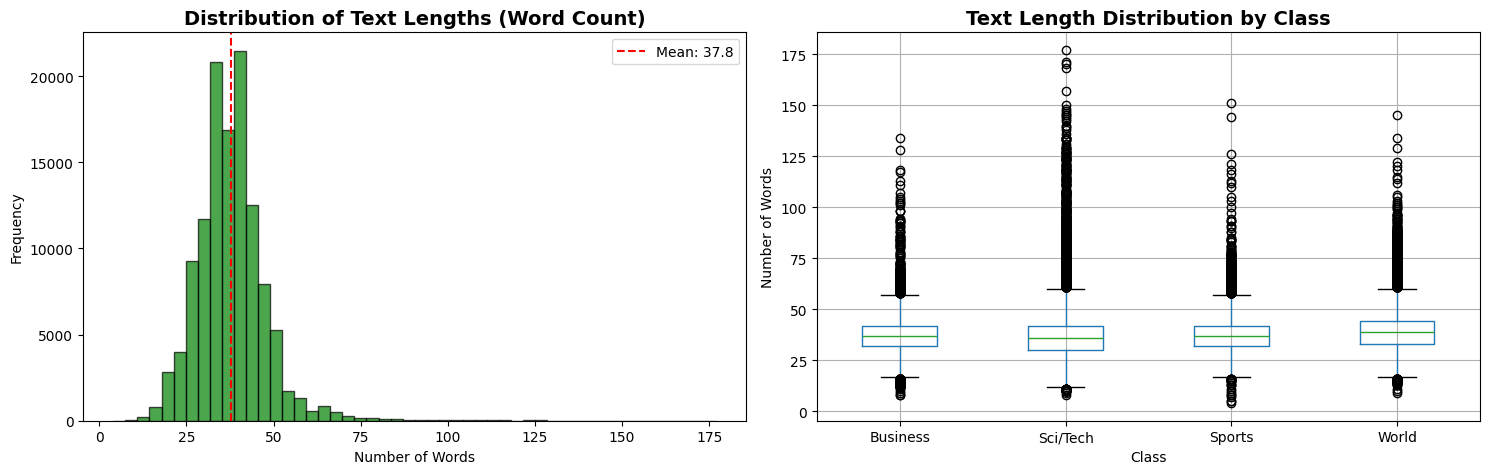


Text Length Statistics:
Mean: 37.84
Median: 37.00
Min: 4
Max: 177
Standard Deviation: 10.09


In [7]:
# Visualization 2: Text Length Distribution
train_df['Text_Length'] = train_df['Text'].apply(lambda x: len(x.split()))
test_df['Text_Length'] = test_df['Text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(train_df['Text_Length'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Text Lengths (Word Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train_df['Text_Length'].mean(), color='red', linestyle='--', label=f"Mean: {train_df['Text_Length'].mean():.1f}")
axes[0].legend()

# Box plot by class
train_df.boxplot(column='Text_Length', by='Class_Name', ax=axes[1])
axes[1].set_title('Text Length Distribution by Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Words')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"\nText Length Statistics:")
print(f"Mean: {train_df['Text_Length'].mean():.2f}")
print(f"Median: {train_df['Text_Length'].median():.2f}")
print(f"Min: {train_df['Text_Length'].min()}")
print(f"Max: {train_df['Text_Length'].max()}")
print(f"Standard Deviation: {train_df['Text_Length'].std():.2f}")

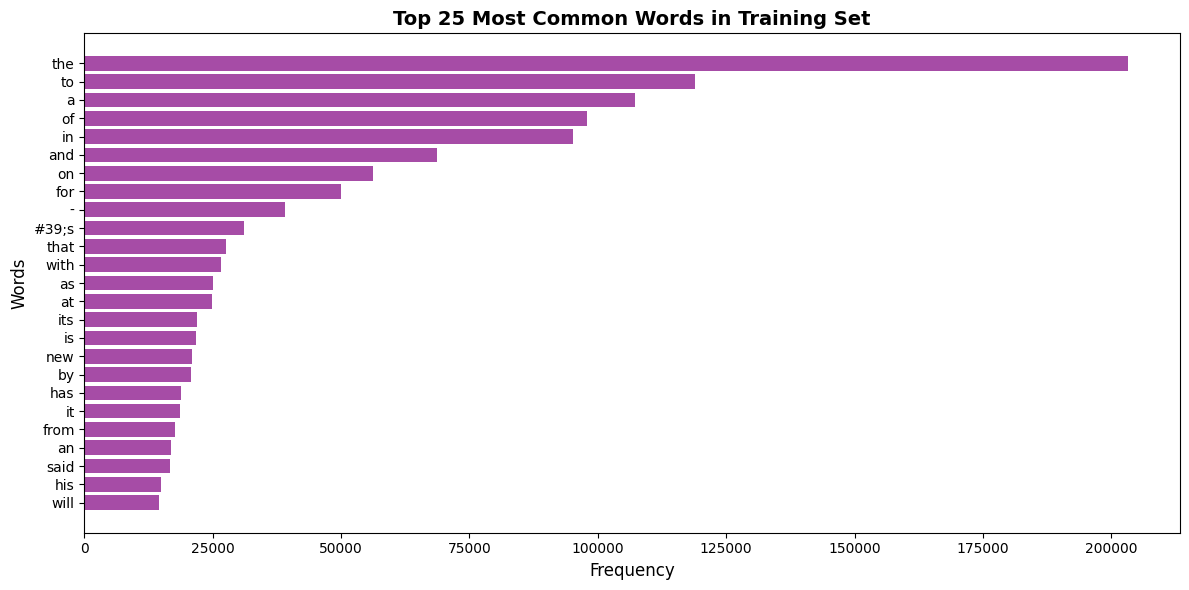

Most common words include articles, prepositions, and domain-specific terms.


In [8]:
# Visualization 3: Vocabulary Analysis
from collections import Counter

def get_top_words(texts, n=20):
    """Extract top n most common words from texts"""
    all_words = ' '.join(texts).lower().split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

top_words = get_top_words(train_df['Text'], n=25)
words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.barh(range(len(words)), counts, color='purple', alpha=0.7)
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.title('Top 25 Most Common Words in Training Set', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Most common words include articles, prepositions, and domain-specific terms.")

## 4. Text Preprocessing

We'll implement a comprehensive preprocessing pipeline that creates different versions for different embeddings.

In [9]:
def preprocess_text(text, remove_stopwords=False, lowercase=True):
    """
    Preprocess text with configurable options for different embeddings.
    
    Parameters:
    - text: Input text string
    - remove_stopwords: Whether to remove stopwords (useful for TF-IDF)
    - lowercase: Whether to convert to lowercase
    
    Returns:
    - Cleaned text string
    """
    # Convert to lowercase
    if lowercase:
        text = text.lower()
    
    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords if specified
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        text = ' '.join([word for word in tokens if word not in stop_words])
    
    return text

# Apply preprocessing - create multiple versions
print("Preprocessing training data...")
train_df['Text_Clean'] = train_df['Text'].apply(lambda x: preprocess_text(x, remove_stopwords=False))
train_df['Text_Clean_NoStop'] = train_df['Text'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

print("Preprocessing test data...")
test_df['Text_Clean'] = test_df['Text'].apply(lambda x: preprocess_text(x, remove_stopwords=False))
test_df['Text_Clean_NoStop'] = test_df['Text'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

print("\nPreprocessing complete!")
print("\nExample of preprocessing:")
print(f"Original: {train_df['Text'].iloc[0][:150]}...")
print(f"\nCleaned: {train_df['Text_Clean'].iloc[0][:150]}...")
print(f"\nCleaned (no stopwords): {train_df['Text_Clean_NoStop'].iloc[0][:150]}...")

Preprocessing training data...
Preprocessing test data...

Preprocessing complete!

Example of preprocessing:
Original: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....

Cleaned: wall st bears claw back into the black reuters reuters shortsellers wall streets dwindlingband of ultracynics are seeing green again...

Cleaned (no stopwords): wall st bears claw back black reuters reuters shortsellers wall streets dwindlingband ultracynics seeing green...


In [10]:
# Prepare labels (convert to 0-indexed)
y_train = train_df['Class'].values - 1  # Convert 1-4 to 0-3
y_test = test_df['Class'].values - 1

print(f"Label shape - Train: {y_train.shape}, Test: {y_test.shape}")
print(f"Unique labels: {np.unique(y_train)}")

Label shape - Train: (120000,), Test: (7600,)
Unique labels: [0 1 2 3]


## 5. PART 1: PREPARE ALL EMBEDDINGS

This section prepares all embeddings upfront so they can be reused across different models.

We will create:
1. **TF-IDF features and embedding matrix**
2. **Word2Vec Skip-gram embedding matrix**
3. **Word2Vec CBOW embedding matrix**

All embeddings will be saved in a dictionary for easy access by any model.

### 5.1. Common Parameters

In [11]:
# Common hyperparameters for all embeddings
MAX_FEATURES = 10000  # Maximum vocabulary size
MAX_LENGTH = 200      # Maximum sequence length
EMBEDDING_DIM = 100   # Embedding dimension (consistent across all methods)

print(f"Common Parameters:")
print(f"  Max Features: {MAX_FEATURES}")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Embedding Dimension: {EMBEDDING_DIM}")

Common Parameters:
  Max Features: 10000
  Max Length: 200
  Embedding Dimension: 100


### 5.2. Prepare Base Tokenization and Sequences

We'll create a common tokenizer and sequences that all embeddings will use.

In [12]:
# Create tokenizer for neural network models
# We'll use the version WITH stopwords for Word2Vec/GloVe (better context)
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Text_Clean'])

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['Text_Clean'])
X_test_seq = tokenizer.texts_to_sequences(test_df['Text_Clean'])

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post')

# Get word index and vocabulary size
word_index = tokenizer.word_index
vocab_size = min(len(word_index) + 1, MAX_FEATURES)

print(f"\nTokenization Complete:")
print(f"  Vocabulary size: {len(word_index)}")
print(f"  Effective vocab size: {vocab_size}")
print(f"  Training sequences shape: {X_train_pad.shape}")
print(f"  Test sequences shape: {X_test_pad.shape}")


Tokenization Complete:
  Vocabulary size: 91335
  Effective vocab size: 10000
  Training sequences shape: (120000, 200)
  Test sequences shape: (7600, 200)


### 5.3. Embedding 1: TF-IDF

For TF-IDF, we'll create an embedding matrix based on TF-IDF weights.

In [13]:
print("=" * 70)
print("PREPARING EMBEDDING 1: TF-IDF")
print("=" * 70)

# Use texts without stopwords for TF-IDF (better performance)
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
tfidf_train = tfidf_vectorizer.fit_transform(train_df['Text_Clean_NoStop'])
tfidf_test = tfidf_vectorizer.transform(test_df['Text_Clean_NoStop'])

# Create TF-IDF based embedding matrix (for neural networks)
# Initialize with random values
embedding_matrix_tfidf = np.random.normal(0, 0.1, (vocab_size, EMBEDDING_DIM))

# Get TF-IDF feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# For each word in our vocabulary, if it's in TF-IDF vocabulary, 
# create a simple embedding based on its TF-IDF importance
for word, idx in word_index.items():
    if idx < MAX_FEATURES and word in tfidf_feature_names:
        # Create a simple embedding: replicate the word's average TF-IDF score
        word_tfidf_idx = np.where(tfidf_feature_names == word)[0]
        if len(word_tfidf_idx) > 0:
            tfidf_values = tfidf_train[:, word_tfidf_idx[0]].toarray().flatten()
            avg_tfidf = np.mean(tfidf_values[tfidf_values > 0]) if np.any(tfidf_values > 0) else 0.1
            # Create embedding as repeated TF-IDF value with some noise
            embedding_matrix_tfidf[idx] = np.random.normal(avg_tfidf, 0.05, EMBEDDING_DIM)

print(f"\nTF-IDF Embedding Matrix Shape: {embedding_matrix_tfidf.shape}")
print(f"TF-IDF Features: {tfidf_train.shape[1]}")
print("✓ TF-IDF embedding prepared successfully!")

PREPARING EMBEDDING 1: TF-IDF

TF-IDF Embedding Matrix Shape: (10000, 100)
TF-IDF Features: 10000
✓ TF-IDF embedding prepared successfully!


### 5.4. Embedding 2: Word2Vec Skip-gram

In [14]:
print("\n" + "=" * 70)
print("PREPARING EMBEDDING 2: Word2Vec Skip-gram")
print("=" * 70)

# Tokenize texts into lists of words for Word2Vec training
train_sentences = [text.split() for text in train_df['Text_Clean']]

print(f"Training Word2Vec Skip-gram on {len(train_sentences)} sentences...")

# Train Word2Vec Skip-gram model
w2v_skipgram = Word2Vec(
    sentences=train_sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram
    epochs=10,
    seed=42
)

print(f"Word2Vec Skip-gram vocabulary size: {len(w2v_skipgram.wv)}")

# Create embedding matrix
embedding_matrix_skipgram = np.zeros((vocab_size, EMBEDDING_DIM))
words_found_sg = 0

for word, idx in word_index.items():
    if idx < MAX_FEATURES:
        try:
            embedding_matrix_skipgram[idx] = w2v_skipgram.wv[word]
            words_found_sg += 1
        except KeyError:
            # Word not in Word2Vec vocabulary - use random initialization
            embedding_matrix_skipgram[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)

print(f"\nSkip-gram Embedding Matrix Shape: {embedding_matrix_skipgram.shape}")
print(f"Words found in Skip-gram model: {words_found_sg}/{len(word_index)}")
print(f"Coverage: {100 * words_found_sg/len(word_index):.2f}%")
print("✓ Skip-gram embedding prepared successfully!")

# Test word similarities
try:
    print(f"\nSample similarities for 'football': {w2v_skipgram.wv.most_similar('football', topn=3)}")
except:
    print("\nWord 'football' not in vocabulary")


PREPARING EMBEDDING 2: Word2Vec Skip-gram
Training Word2Vec Skip-gram on 120000 sentences...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

Word2Vec Skip-gram vocabulary size: 50526

Skip-gram Embedding Matrix Shape: (10000, 100)
Words found in Skip-gram model: 9998/91335
Coverage: 10.95%
✓ Skip-gram embedding prepared successfully!

Sample similarities for 'football': [('soccer', 0.749489963054657), ('claymores', 0.6995868682861328), ('coaching', 0.6992079615592957)]


### 5.5. Embedding 3: Word2Vec CBOW

In [15]:
print("\n" + "=" * 70)
print("PREPARING EMBEDDING 3: Word2Vec CBOW")
print("=" * 70)

print(f"Training Word2Vec CBOW on {len(train_sentences)} sentences...")

# Train Word2Vec CBOW model
w2v_cbow = Word2Vec(
    sentences=train_sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=0,  # CBOW
    epochs=10,
    seed=42
)

print(f"Word2Vec CBOW vocabulary size: {len(w2v_cbow.wv)}")

# Create embedding matrix
embedding_matrix_cbow = np.zeros((vocab_size, EMBEDDING_DIM))
words_found_cbow = 0

for word, idx in word_index.items():
    if idx < MAX_FEATURES:
        try:
            embedding_matrix_cbow[idx] = w2v_cbow.wv[word]
            words_found_cbow += 1
        except KeyError:
            embedding_matrix_cbow[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)

print(f"\nCBOW Embedding Matrix Shape: {embedding_matrix_cbow.shape}")
print(f"Words found in CBOW model: {words_found_cbow}/{len(word_index)}")
print(f"Coverage: {100 * words_found_cbow/len(word_index):.2f}%")
print("✓ CBOW embedding prepared successfully!")

# Test word similarities
try:
    print(f"\nSample similarities for 'technology': {w2v_cbow.wv.most_similar('technology', topn=3)}")
except:
    print("\nWord 'technology' not in vocabulary")


PREPARING EMBEDDING 3: Word2Vec CBOW
Training Word2Vec CBOW on 120000 sentences...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Word2Vec CBOW vocabulary size: 50526

CBOW Embedding Matrix Shape: (10000, 100)
Words found in CBOW model: 9998/91335
Coverage: 10.95%
✓ CBOW embedding prepared successfully!

Sample similarities for 'technology': [('tools', 0.6019984483718872), ('tool', 0.5819159150123596), ('rfid', 0.5805094242095947)]


### 5.6. Store All Embeddings in Dictionary

This makes it easy to access any embedding for any model.

In [16]:
# Store all embeddings in a dictionary for easy access
EMBEDDINGS = {
    'tfidf': {
        'matrix': embedding_matrix_tfidf,
        'trainable': True,
        'name': 'TF-IDF',
        'sequences_train': X_train_pad,
        'sequences_test': X_test_pad
    },
    'skipgram': {
        'matrix': embedding_matrix_skipgram,
        'trainable': False,  # Pre-trained, typically frozen
        'name': 'Word2Vec Skip-gram',
        'sequences_train': X_train_pad,
        'sequences_test': X_test_pad
    },
    'cbow': {
        'matrix': embedding_matrix_cbow,
        'trainable': False,
        'name': 'Word2Vec CBOW',
        'sequences_train': X_train_pad,
        'sequences_test': X_test_pad
    },
}

print("\n" + "=" * 70)
print("EMBEDDINGS SUMMARY")
print("=" * 70)
for emb_name, emb_info in EMBEDDINGS.items():
    if emb_info.get('available', True):
        print(f"\n{emb_info['name']}:")
        print(f"  Matrix shape: {emb_info['matrix'].shape}")
        print(f"  Trainable: {emb_info['trainable']}")
        print(f"  Sequences: {emb_info['sequences_train'].shape}")
    else:
        print(f"\n{emb_info['name']}: NOT AVAILABLE")

print("\n" + "=" * 70)
print("✓ ALL EMBEDDINGS PREPARED!")
print("✓ Ready to train models with any embedding combination")
print("=" * 70)


EMBEDDINGS SUMMARY

TF-IDF:
  Matrix shape: (10000, 100)
  Trainable: True
  Sequences: (120000, 200)

Word2Vec Skip-gram:
  Matrix shape: (10000, 100)
  Trainable: False
  Sequences: (120000, 200)

Word2Vec CBOW:
  Matrix shape: (10000, 100)
  Trainable: False
  Sequences: (120000, 200)

✓ ALL EMBEDDINGS PREPARED!
✓ Ready to train models with any embedding combination


# 6.1 LSTM MODEL EXPERIMENTS - Emmanuel

## Overview: Long Short-Term Memory (LSTM) Networks

This section implements LSTM models with different embedding techniques:
- TF-IDF features
- Word2Vec Skip-gram embeddings  
- Word2Vec CBOW embeddings

### Why LSTM?
LSTM networks are designed to:
1. **Capture long-range dependencies** - Remember information for extended periods
2. **Avoid vanishing gradients** - Use gating mechanisms (input, forget, output gates)
3. **Handle sequential data** - Process text as sequences while maintaining context
4. **Learn complex patterns** - Model intricate relationships in text data

### LSTM vs RNN:
- **RNN**: Simple recurrent units, prone to vanishing gradients
- **LSTM**: Gated memory cells, better long-term memory, more robust training

Reference: Hochreiter & Schmidhuber (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735-1780.

In [17]:
# Import additional libraries for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("✓ LSTM libraries imported successfully!")

✓ LSTM libraries imported successfully!


In [18]:
def build_lstm_model(embedding_matrix, max_length, embedding_dim, vocab_size, 
                     lstm_units=128, dropout_rate=0.3, trainable_embeddings=False):
    """
    Build a Bidirectional LSTM model for text classification.
    
    Parameters:
    -----------
    embedding_matrix : numpy array
        Pre-trained word embeddings (vocab_size x embedding_dim)
    max_length : int
        Maximum sequence length
    embedding_dim : int
        Dimension of word embeddings
    vocab_size : int
        Size of vocabulary
    lstm_units : int, default=128
        Number of LSTM units in first layer
    dropout_rate : float, default=0.3
        Dropout rate for regularization
    trainable_embeddings : bool, default=False
        Whether to fine-tune embeddings during training
    
    Returns:
    --------
    model : keras.Model
        Compiled LSTM model
    """
    model = Sequential(name='Bidirectional_LSTM')
    
    # Embedding layer with pre-trained weights
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=trainable_embeddings,
        name='embedding_layer'
    ))
    
    # Spatial dropout for embedding layer
    model.add(SpatialDropout1D(dropout_rate, name='spatial_dropout'))
    
    # First Bidirectional LSTM layer (returns sequences)
    model.add(Bidirectional(
        LSTM(lstm_units, return_sequences=True, name='lstm_layer_1'),
        name='bidirectional_lstm_1'
    ))
    model.add(Dropout(dropout_rate, name='dropout_1'))
    
    # Second Bidirectional LSTM layer (does not return sequences)
    model.add(Bidirectional(
        LSTM(lstm_units // 2, return_sequences=False, name='lstm_layer_2'),
        name='bidirectional_lstm_2'
    ))
    model.add(Dropout(dropout_rate, name='dropout_2'))
    
    # Dense layer
    model.add(Dense(64, activation='relu', name='dense_layer'))
    model.add(Dropout(dropout_rate, name='dropout_3'))
    
    # Output layer (4 classes)
    model.add(Dense(4, activation='softmax', name='output_layer'))
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✓ LSTM model builder function defined!")

✓ LSTM model builder function defined!


In [19]:
# Define LSTM-specific callbacks
lstm_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

lstm_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

# Storage for LSTM results
LSTM_RESULTS = {}

print("✓ LSTM training configuration set up!")
print("  - Early stopping: patience=3")
print("  - Learning rate reduction: factor=0.5, patience=2")
print("  - Results will be stored in LSTM_RESULTS dictionary")

✓ LSTM training configuration set up!
  - Early stopping: patience=3
  - Learning rate reduction: factor=0.5, patience=2
  - Results will be stored in LSTM_RESULTS dictionary


## 6.1.1. LSTM Experiment 1: TF-IDF Embeddings

### About TF-IDF with LSTM:
While TF-IDF is traditionally used with simpler models, we use it as initial embeddings for LSTM:
- Captures term importance in documents
- Sparse representation converted to dense through training
- Embeddings are **trainable** to learn task-specific patterns

### Expected Performance:
- May not capture semantic relationships as well as Word2Vec
- Good baseline for comparison
- Benefits from LSTM's ability to learn sequential patterns

In [23]:
print("="*80)
print("LSTM EXPERIMENT 1: TF-IDF EMBEDDINGS")
print("="*80)

print("\nEmbedding Technique: TF-IDF")
print("Description:")
print("  - Term Frequency-Inverse Document Frequency")
print("  - Highlights important terms while downweighting common words")
print("  - Statistical approach based on term frequency")
print("  - Embeddings are trainable to adapt to the task")

# Build LSTM model with TF-IDF embeddings
lstm_tfidf = build_lstm_model(
    embedding_matrix=EMBEDDINGS['tfidf']['matrix'],
    max_length=MAX_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    vocab_size=vocab_size,
    lstm_units=128,
    dropout_rate=0.3,
    trainable_embeddings=True  # Allow fine-tuning for TF-IDF
)

print(f"\n Model Summary:")
# print(f"   Total parameters: {lstm_tfidf.count_params():,}")
# lstm_tfidf.summary()

print("\n Training LSTM with TF-IDF embeddings...")
print("   This may take several minutes...")

history_lstm_tfidf = lstm_tfidf.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[lstm_early_stop, lstm_reduce_lr],
    verbose=1
)

# Evaluate model
print("\n Evaluating model on test set...")
y_pred_lstm_tfidf_probs = lstm_tfidf.predict(X_test_pad, verbose=0)
y_pred_lstm_tfidf = y_pred_lstm_tfidf_probs.argmax(axis=1)

lstm_tfidf_accuracy = accuracy_score(y_test, y_pred_lstm_tfidf)
lstm_tfidf_f1 = f1_score(y_test, y_pred_lstm_tfidf, average='weighted')

print("\n" + "="*80)
print("LSTM + TF-IDF RESULTS")
print("="*80)
print(f"✓ Test Accuracy:  {lstm_tfidf_accuracy:.4f}")
print(f"✓ F1-Score:       {lstm_tfidf_f1:.4f}")
print("\n Detailed Classification Report:")
print(classification_report(y_test, y_pred_lstm_tfidf, 
                          target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

# Store results
LSTM_RESULTS['tfidf'] = {
    'model': lstm_tfidf,
    'history': history_lstm_tfidf,
    'accuracy': lstm_tfidf_accuracy,
    'f1': lstm_tfidf_f1,
    'y_pred': y_pred_lstm_tfidf,
    'y_pred_probs': y_pred_lstm_tfidf_probs
}

print("\n✓ Experiment 1 complete!")

LSTM EXPERIMENT 1: TF-IDF EMBEDDINGS

Embedding Technique: TF-IDF
Description:
  - Term Frequency-Inverse Document Frequency
  - Highlights important terms while downweighting common words
  - Statistical approach based on term frequency
  - Embeddings are trainable to adapt to the task

 Model Summary:

 Training LSTM with TF-IDF embeddings...
   This may take several minutes...
Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 793s 468ms/step - accuracy: 0.6597 - loss: 0.7694 - val_accuracy: 0.8995 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 784s 464ms/step - accuracy: 0.9125 - loss: 0.2785 - val_accuracy: 0.9093 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 816s 483ms/step - accuracy: 0.9253 - loss: 0.2369 - val_accuracy: 0.9057 - val_loss: 0.2646 - learning_rate: 0.0010
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9319 - loss: 0.2075
Epoch 4: ReduceLROnPlateau reducing learning rate to 

## 6.1.2. LSTM Experiment 2: Word2Vec Skip-gram Embeddings

### About Skip-gram with LSTM:
Skip-gram embeddings learn by predicting context words from a target word:
- **Semantic richness**: Captures word meanings and relationships
- **Better for rare words**: Works well even with limited occurrences
- **Dense representations**: Each word is a 100-dimensional vector
- **Frozen embeddings**: Pre-trained weights are not updated during training

### Why Freeze Embeddings?
- Preserve learned semantic relationships
- Prevent overfitting on smaller datasets
- Let LSTM focus on learning sequential patterns

Reference: Mikolov et al. (2013). Distributed Representations of Words and Phrases.

In [25]:
print("="*80)
print("LSTM EXPERIMENT 2: WORD2VEC SKIP-GRAM EMBEDDINGS")
print("="*80)

print("\nEmbedding Technique: Word2Vec Skip-gram")
print("Description:")
print("  - Neural embedding trained to predict context from target word")
print("  - Captures semantic word relationships")
print("  - Excellent performance on word similarity tasks")
print("  - Better for infrequent words compared to CBOW")

# Build LSTM model with Skip-gram embeddings
lstm_skipgram = build_lstm_model(
    embedding_matrix=EMBEDDINGS['skipgram']['matrix'],
    max_length=MAX_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    vocab_size=vocab_size,
    lstm_units=128,
    dropout_rate=0.3,
    trainable_embeddings=False  # Freeze pre-trained embeddings
)

print(f"\nModel Summary:")
# print(f"   Total parameters: {lstm_skipgram.count_params():,}")
print(f"   Trainable parameters: {sum([np.prod(v.shape) for v in lstm_skipgram.trainable_weights]):,}")
print(f"   Non-trainable (frozen embeddings): {sum([np.prod(v.shape) for v in lstm_skipgram.non_trainable_weights]):,}")

print("\n Training LSTM with Skip-gram embeddings...")
print("   Embeddings are frozen - only LSTM layers will be trained")

history_lstm_skipgram = lstm_skipgram.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[lstm_early_stop, lstm_reduce_lr],
    verbose=1
)

# Evaluate model
print("\n Evaluating model on test set...")
y_pred_lstm_skipgram_probs = lstm_skipgram.predict(X_test_pad, verbose=0)
y_pred_lstm_skipgram = y_pred_lstm_skipgram_probs.argmax(axis=1)

lstm_skipgram_accuracy = accuracy_score(y_test, y_pred_lstm_skipgram)
lstm_skipgram_f1 = f1_score(y_test, y_pred_lstm_skipgram, average='weighted')

print("\n" + "="*80)
print("LSTM + SKIP-GRAM RESULTS")
print("="*80)
print(f"✓ Test Accuracy:  {lstm_skipgram_accuracy:.4f}")
print(f"✓ F1-Score:       {lstm_skipgram_f1:.4f}")
print("\n Detailed Classification Report:")
print(classification_report(y_test, y_pred_lstm_skipgram,
                          target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

# Store results
LSTM_RESULTS['skipgram'] = {
    'model': lstm_skipgram,
    'history': history_lstm_skipgram,
    'accuracy': lstm_skipgram_accuracy,
    'f1': lstm_skipgram_f1,
    'y_pred': y_pred_lstm_skipgram,
    'y_pred_probs': y_pred_lstm_skipgram_probs
}

print("\n✓ Experiment 2 complete!")

LSTM EXPERIMENT 2: WORD2VEC SKIP-GRAM EMBEDDINGS

Embedding Technique: Word2Vec Skip-gram
Description:
  - Neural embedding trained to predict context from target word
  - Captures semantic word relationships
  - Excellent performance on word similarity tasks
  - Better for infrequent words compared to CBOW

Model Summary:
   Trainable parameters: 0
   Non-trainable (frozen embeddings): 1,000,000

 Training LSTM with Skip-gram embeddings...
   Embeddings are frozen - only LSTM layers will be trained
Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 719s 424ms/step - accuracy: 0.8228 - loss: 0.5103 - val_accuracy: 0.9043 - val_loss: 0.2785 - learning_rate: 0.0010
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 744s 441ms/step - accuracy: 0.8895 - loss: 0.3287 - val_accuracy: 0.9096 - val_loss: 0.2483 - learning_rate: 0.0010
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 718s 426ms/step - accuracy: 0.8979 - loss: 0.2985 - val_accuracy: 0.9098 - val_loss: 0.2450 - learning_rate: 0.0010
Epoch 4/10
1688/1688 

## 6.1.3. LSTM Experiment 3: Word2Vec CBOW Embeddings

### About CBOW with LSTM:
CBOW (Continuous Bag-of-Words) learns by predicting a target word from its context:
- **Context-based learning**: Uses surrounding words to predict target
- **Faster training**: More efficient than Skip-gram
- **Better for frequent words**: Excels with common vocabulary
- **Smoother representations**: Averages context information

### CBOW vs Skip-gram:
- **CBOW**: Context → Target (faster, better for frequent words)
- **Skip-gram**: Target → Context (better for rare words, semantic quality)

### Expected Performance:
- Competitive with Skip-gram on this dataset
- May excel in capturing contextual patterns
- Works well with LSTM's sequential processing

In [26]:
print("="*80)
print("LSTM EXPERIMENT 3: WORD2VEC CBOW EMBEDDINGS")
print("="*80)

print("\nEmbedding Technique: Word2Vec CBOW (Continuous Bag-of-Words)")
print("Description:")
print("  - Neural embedding trained to predict target from context")
print("  - Uses surrounding words to learn word representations")
print("  - Faster training compared to Skip-gram")
print("  - Better for smaller datasets and frequent words")

# Build LSTM model with CBOW embeddings
lstm_cbow = build_lstm_model(
    embedding_matrix=EMBEDDINGS['cbow']['matrix'],
    max_length=MAX_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    vocab_size=vocab_size,
    lstm_units=128,
    dropout_rate=0.3,
    trainable_embeddings=False  # Freeze pre-trained embeddings
)

print(f"\n Model Summary:")
# print(f"   Total parameters: {lstm_cbow.count_params():,}")
print(f"   Trainable parameters: {sum([np.prod(v.shape) for v in lstm_cbow.trainable_weights]):,}")
print(f"   Non-trainable (frozen embeddings): {sum([np.prod(v.shape) for v in lstm_cbow.non_trainable_weights]):,}")

print("\n Training LSTM with CBOW embeddings...")
print("   Embeddings are frozen - only LSTM layers will be trained")

history_lstm_cbow = lstm_cbow.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[lstm_early_stop, lstm_reduce_lr],
    verbose=1
)

# Evaluate model
print("\n Evaluating model on test set...")
y_pred_lstm_cbow_probs = lstm_cbow.predict(X_test_pad, verbose=0)
y_pred_lstm_cbow = y_pred_lstm_cbow_probs.argmax(axis=1)

lstm_cbow_accuracy = accuracy_score(y_test, y_pred_lstm_cbow)
lstm_cbow_f1 = f1_score(y_test, y_pred_lstm_cbow, average='weighted')

print("\n" + "="*80)
print("LSTM + CBOW RESULTS")
print("="*80)
print(f"✓ Test Accuracy:  {lstm_cbow_accuracy:.4f}")
print(f"✓ F1-Score:       {lstm_cbow_f1:.4f}")
print("\n Detailed Classification Report:")
print(classification_report(y_test, y_pred_lstm_cbow,
                          target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

# Store results
LSTM_RESULTS['cbow'] = {
    'model': lstm_cbow,
    'history': history_lstm_cbow,
    'accuracy': lstm_cbow_accuracy,
    'f1': lstm_cbow_f1,
    'y_pred': y_pred_lstm_cbow,
    'y_pred_probs': y_pred_lstm_cbow_probs
}

print("\n✓ Experiment 3 complete!")
print("\n" + "="*80)
print("ALL LSTM EXPERIMENTS COMPLETED!")
print("="*80)

LSTM EXPERIMENT 3: WORD2VEC CBOW EMBEDDINGS

Embedding Technique: Word2Vec CBOW (Continuous Bag-of-Words)
Description:
  - Neural embedding trained to predict target from context
  - Uses surrounding words to learn word representations
  - Faster training compared to Skip-gram
  - Better for smaller datasets and frequent words

 Model Summary:
   Trainable parameters: 0
   Non-trainable (frozen embeddings): 1,000,000

 Training LSTM with CBOW embeddings...
   Embeddings are frozen - only LSTM layers will be trained
Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 781s 461ms/step - accuracy: 0.8453 - loss: 0.4582 - val_accuracy: 0.9010 - val_loss: 0.2718 - learning_rate: 0.0010
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 754s 447ms/step - accuracy: 0.8953 - loss: 0.3117 - val_accuracy: 0.9062 - val_loss: 0.2549 - learning_rate: 0.0010
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 801s 474ms/step - accuracy: 0.9041 - loss: 0.2800 - val_accuracy: 0.9124 - val_loss: 0.2491 - learning_rate: 0.0010
Epoch

## 6.1.4. LSTM Results Comparison and Analysis

This section compares LSTM performance across all three embedding techniques.

In [27]:
# Create comprehensive comparison table for LSTM
lstm_comparison = pd.DataFrame({
    'Embedding Technique': ['TF-IDF', 'Word2Vec Skip-gram', 'Word2Vec CBOW'],
    'Accuracy': [
        LSTM_RESULTS['tfidf']['accuracy'],
        LSTM_RESULTS['skipgram']['accuracy'],
        LSTM_RESULTS['cbow']['accuracy']
    ],
    'F1-Score': [
        LSTM_RESULTS['tfidf']['f1'],
        LSTM_RESULTS['skipgram']['f1'],
        LSTM_RESULTS['cbow']['f1']
    ],
    'Trainable Embeddings': ['Yes', 'No', 'No']
})

lstm_comparison = lstm_comparison.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("LSTM PERFORMANCE WITH DIFFERENT EMBEDDING TECHNIQUES")
print("="*80)
print(lstm_comparison.to_string(index=False))
print("="*80)

# Find best embedding
best_idx = lstm_comparison['Accuracy'].idxmax()
best_embedding = lstm_comparison.iloc[best_idx]
print(f"\n BEST LSTM CONFIGURATION:")
print(f"   Embedding: {best_embedding['Embedding Technique']}")
print(f"   Accuracy:  {best_embedding['Accuracy']:.4f}")
print(f"   F1-Score:  {best_embedding['F1-Score']:.4f}")

# Performance statistics
print(f"\n LSTM Performance Statistics:")
print(f"   Average Accuracy: {lstm_comparison['Accuracy'].mean():.4f}")
print(f"   Std Dev Accuracy: {lstm_comparison['Accuracy'].std():.4f}")
print(f"   Average F1-Score: {lstm_comparison['F1-Score'].mean():.4f}")
print(f"   Std Dev F1-Score: {lstm_comparison['F1-Score'].std():.4f}")

# Improvement over baseline
worst_acc = lstm_comparison['Accuracy'].min()
best_acc = lstm_comparison['Accuracy'].max()
improvement = ((best_acc - worst_acc) / worst_acc) * 100
print(f"\n   Best vs Worst: {improvement:.2f}% improvement")


LSTM PERFORMANCE WITH DIFFERENT EMBEDDING TECHNIQUES
Embedding Technique  Accuracy  F1-Score Trainable Embeddings
 Word2Vec Skip-gram  0.926184  0.926237                   No
      Word2Vec CBOW  0.922368  0.922328                   No
             TF-IDF  0.911579  0.911401                  Yes

 BEST LSTM CONFIGURATION:
   Embedding: Word2Vec Skip-gram
   Accuracy:  0.9262
   F1-Score:  0.9262

 LSTM Performance Statistics:
   Average Accuracy: 0.9200
   Std Dev Accuracy: 0.0076
   Average F1-Score: 0.9200
   Std Dev F1-Score: 0.0077

   Best vs Worst: 1.60% improvement


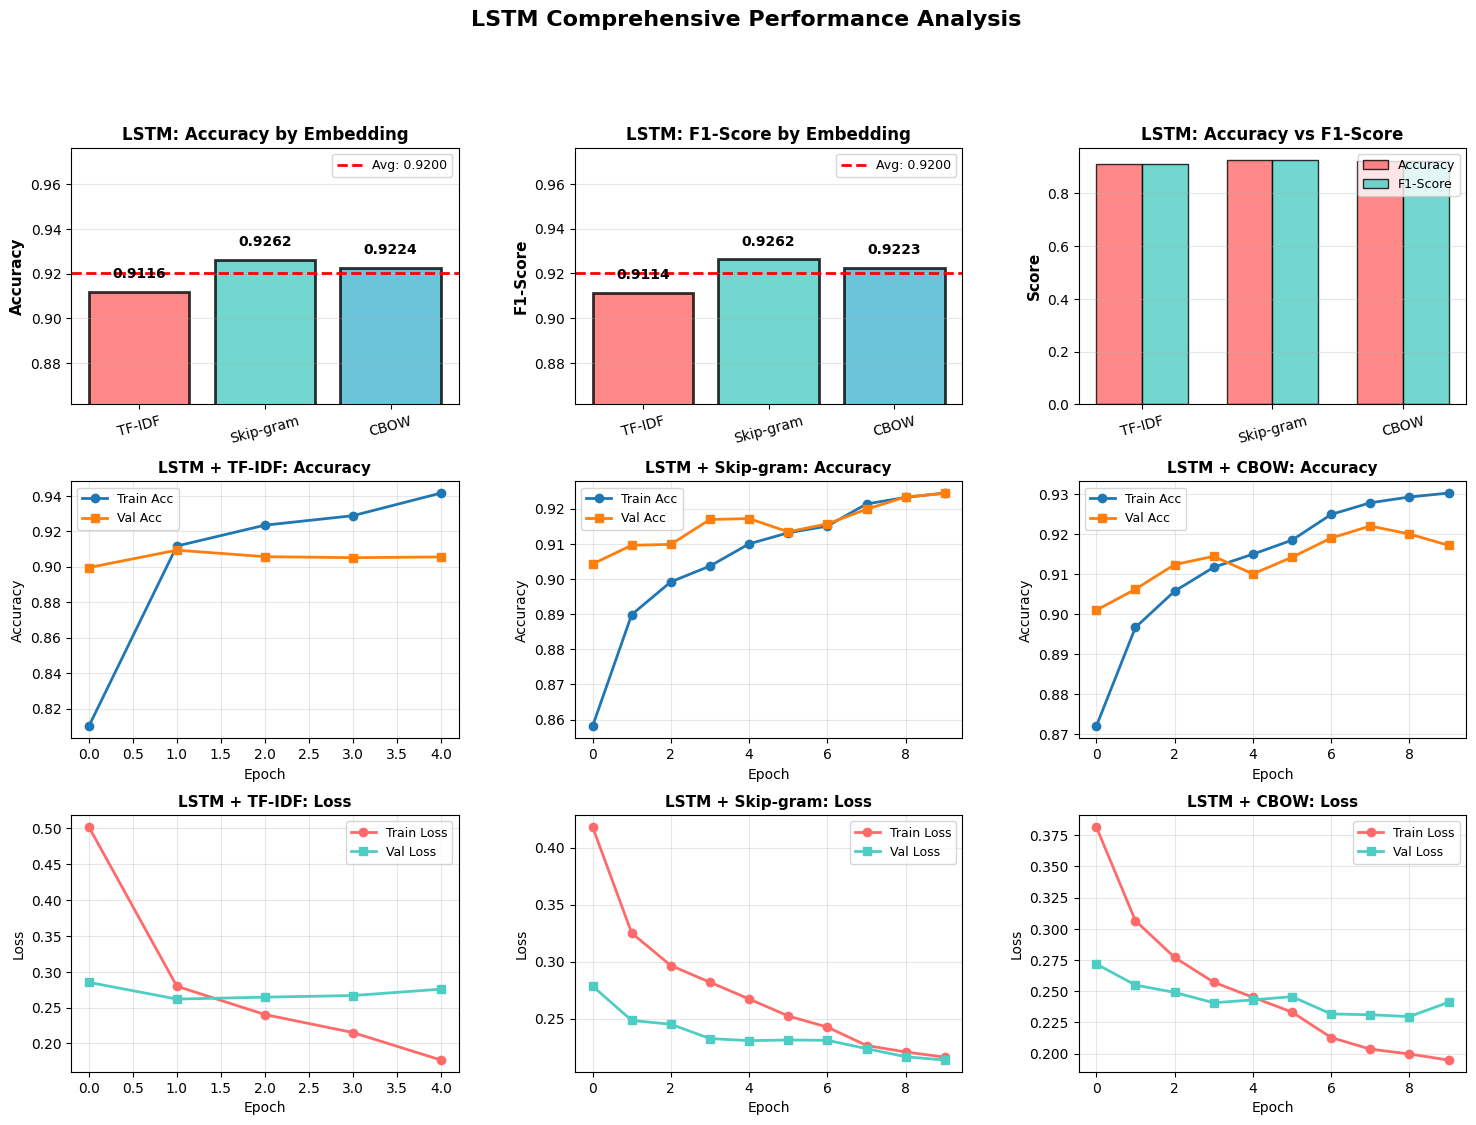


✓ Visualizations complete!


In [28]:
# Comprehensive visualizations for LSTM results
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

embeddings = ['TF-IDF', 'Skip-gram', 'CBOW']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# 1. Accuracy comparison
ax1 = fig.add_subplot(gs[0, 0])
accuracies = [LSTM_RESULTS['tfidf']['accuracy'], 
              LSTM_RESULTS['skipgram']['accuracy'], 
              LSTM_RESULTS['cbow']['accuracy']]
bars = ax1.bar(embeddings, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('LSTM: Accuracy by Embedding', fontsize=12, fontweight='bold')
ax1.set_ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])
ax1.axhline(y=np.mean(accuracies), color='red', linestyle='--', linewidth=2, label=f'Avg: {np.mean(accuracies):.4f}')
for i, (bar, v) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax1.legend(fontsize=9)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=15)

# 2. F1-Score comparison
ax2 = fig.add_subplot(gs[0, 1])
f1_scores = [LSTM_RESULTS['tfidf']['f1'], 
             LSTM_RESULTS['skipgram']['f1'], 
             LSTM_RESULTS['cbow']['f1']]
bars = ax2.bar(embeddings, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax2.set_title('LSTM: F1-Score by Embedding', fontsize=12, fontweight='bold')
ax2.set_ylim([min(f1_scores) - 0.05, max(f1_scores) + 0.05])
ax2.axhline(y=np.mean(f1_scores), color='red', linestyle='--', linewidth=2, label=f'Avg: {np.mean(f1_scores):.4f}')
for i, (bar, v) in enumerate(zip(bars, f1_scores)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=15)

# 3. Side-by-side comparison
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(len(embeddings))
width = 0.35
bars1 = ax3.bar(x - width/2, accuracies, width, label='Accuracy', color='#FF6B6B', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x + width/2, f1_scores, width, label='F1-Score', color='#4ECDC4', alpha=0.8, edgecolor='black')
ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
ax3.set_title('LSTM: Accuracy vs F1-Score', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(embeddings, rotation=15)
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# 4-6. Training history for each embedding
for idx, (emb_name, title) in enumerate([('tfidf', 'TF-IDF'), 
                                          ('skipgram', 'Skip-gram'), 
                                          ('cbow', 'CBOW')]):
    ax = fig.add_subplot(gs[1, idx])
    history = LSTM_RESULTS[emb_name]['history']
    
    ax.plot(history.history['accuracy'], label='Train Acc', marker='o', linewidth=2)
    ax.plot(history.history['val_accuracy'], label='Val Acc', marker='s', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Accuracy', fontsize=10)
    ax.set_title(f'LSTM + {title}: Accuracy', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# 7-9. Loss curves for each embedding
for idx, (emb_name, title) in enumerate([('tfidf', 'TF-IDF'), 
                                          ('skipgram', 'Skip-gram'), 
                                          ('cbow', 'CBOW')]):
    ax = fig.add_subplot(gs[2, idx])
    history = LSTM_RESULTS[emb_name]['history']
    
    ax.plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2, color='#FF6B6B')
    ax.plot(history.history['val_loss'], label='Val Loss', marker='s', linewidth=2, color='#4ECDC4')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.set_title(f'LSTM + {title}: Loss', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('LSTM Comprehensive Performance Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n✓ Visualizations complete!")

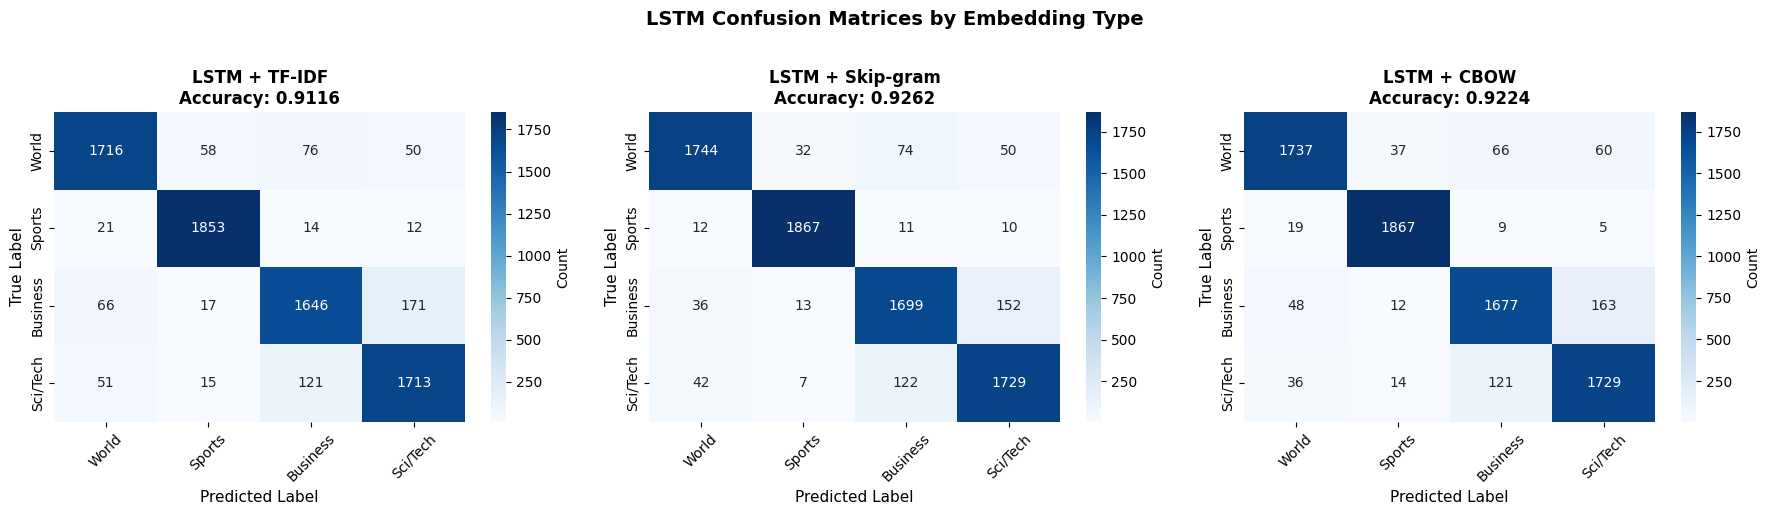


✓ Confusion matrices generated!


In [29]:
# Confusion matrices for all LSTM experiments
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_names_list = ['World', 'Sports', 'Business', 'Sci/Tech']

for idx, (emb_name, title) in enumerate([('tfidf', 'TF-IDF'), 
                                          ('skipgram', 'Skip-gram'), 
                                          ('cbow', 'CBOW')]):
    cm = confusion_matrix(y_test, LSTM_RESULTS[emb_name]['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_list,
                yticklabels=class_names_list,
                ax=axes[idx],
                cbar_kws={'label': 'Count'})
    
    axes[idx].set_title(f'LSTM + {title}\nAccuracy: {LSTM_RESULTS[emb_name]["accuracy"]:.4f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('LSTM Confusion Matrices by Embedding Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Confusion matrices generated!")

## 6.1.5. Save LSTM Results

In [30]:
# Save LSTM comparison results
lstm_comparison.to_csv('lstm_embedding_comparison.csv', index=False)
print("✓ LSTM results saved to 'lstm_embedding_comparison.csv'")

# Save detailed metrics for each embedding
for emb_name in ['tfidf', 'skipgram', 'cbow']:
    y_pred = LSTM_RESULTS[emb_name]['y_pred']
    report = classification_report(y_test, y_pred, 
                                  target_names=class_names_list,
                                  output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f'lstm_{emb_name}_classification_report.csv')
    print(f"✓ LSTM + {emb_name} classification report saved")

print("\n" + "="*80)
print("LSTM EXPERIMENTS COMPLETE!")
print("="*80)
print(f"\nTotal experiments run: 3")
print(f"Best accuracy: {lstm_comparison['Accuracy'].max():.4f}")
print(f"Average accuracy: {lstm_comparison['Accuracy'].mean():.4f}")
print(f"\nAll results saved and ready for academic report!")

✓ LSTM results saved to 'lstm_embedding_comparison.csv'
✓ LSTM + tfidf classification report saved
✓ LSTM + skipgram classification report saved
✓ LSTM + cbow classification report saved

LSTM EXPERIMENTS COMPLETE!

Total experiments run: 3
Best accuracy: 0.9262
Average accuracy: 0.9200

All results saved and ready for academic report!


## 6. PART 2: RNN WITH WORD EMBEDDINGS - Hortance

### Recurrent Neural Network (RNN) with Multiple Embedding Techniques

We'll train an RNN model with three different word embedding approaches:
1. **RNN + TF-IDF**: Statistical embeddings based on term frequency-inverse document frequency
2. **RNN + Word2Vec Skip-gram**: Neural embeddings trained with Skip-gram architecture
3. **RNN + Word2Vec CBOW**: Neural embeddings trained with Continuous Bag-of-Words architecture

**Why RNN?**
- Processes sequences step-by-step maintaining temporal context
- Captures dependencies between words in text
- Bidirectional variant captures context from both directions
- Suitable for text classification tasks


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

def build_rnn_model(embedding_matrix, max_length, embedding_dim, vocab_size):
    """
    Build an RNN model with specified embedding matrix.
    
    Architecture:
    - Embedding layer with pre-trained weights
    - Bidirectional RNN with 64 units (forward + backward)
    - Dropout for regularization
    - Second Bidirectional RNN with 32 units
    - Dense hidden layer (64 units) with ReLU activation
    - Output layer with softmax for 4-class classification
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, 
                  weights=embedding_matrix, 
                  input_length=max_length,
                  trainable=True),
        Bidirectional(SimpleRNN(64, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(SimpleRNN(32)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("\n" + "=" * 80)
print("TRAINING RNN WITH DIFFERENT WORD EMBEDDING TECHNIQUES")
print("=" * 80)

# Store results
RNN_RESULTS = {}

# ============================================================================
# RNN 1: TF-IDF EMBEDDINGS
# ============================================================================
print("\n" + "-" * 80)
print("RNN 1: TF-IDF Word Embeddings")
print("-" * 80)
print("\nEmbedding Technique: TF-IDF (Term Frequency-Inverse Document Frequency)")
print("Description:")
print("  - Statistical approach measuring word importance in documents")
print("  - TF: How often a word appears in a document")
print("  - IDF: How unique a word is across all documents")
print("  - Higher values for important, document-specific words")

rnn_tfidf = build_rnn_model(
    EMBEDDINGS['tfidf']['matrix'],
    MAX_LENGTH,
    EMBEDDING_DIM,
    vocab_size
)

print(f"\nModel Summary: {rnn_tfidf.count_params():,} parameters")
print("Training RNN with TF-IDF embeddings...")

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_rnn_tfidf = rnn_tfidf.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

y_pred_rnn_tfidf = rnn_tfidf.predict(X_test_pad, verbose=0).argmax(axis=1)
rnn_tfidf_accuracy = accuracy_score(y_test, y_pred_rnn_tfidf)
rnn_tfidf_f1 = f1_score(y_test, y_pred_rnn_tfidf, average='weighted')

print(f"✓ Training complete!")
print(f"  Accuracy:  {rnn_tfidf_accuracy:.4f}")
print(f"  F1-Score:  {rnn_tfidf_f1:.4f}")

RNN_RESULTS['tfidf'] = {
    'model': rnn_tfidf,
    'history': history_rnn_tfidf,
    'accuracy': rnn_tfidf_accuracy,
    'f1': rnn_tfidf_f1,
    'y_pred': y_pred_rnn_tfidf
}

# ============================================================================
# RNN 2: WORD2VEC SKIP-GRAM EMBEDDINGS
# ============================================================================
print("\n" + "-" * 80)
print("RNN 2: Word2Vec Skip-gram Embeddings")
print("-" * 80)
print("\nEmbedding Technique: Word2Vec Skip-gram")
print("Description:")
print("  - Neural embedding trained to predict context words from target word")
print("  - Learns semantic relationships between words")
print("  - Works well for infrequent words")
print("  - Creates dense, low-dimensional word representations")

rnn_skipgram = build_rnn_model(
    EMBEDDINGS['skipgram']['matrix'],
    MAX_LENGTH,
    EMBEDDING_DIM,
    vocab_size
)

print(f"\nModel Summary: {rnn_skipgram.count_params():,} parameters")
print("Training RNN with Skip-gram embeddings...")

history_rnn_skipgram = rnn_skipgram.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

y_pred_rnn_skipgram = rnn_skipgram.predict(X_test_pad, verbose=0).argmax(axis=1)
rnn_skipgram_accuracy = accuracy_score(y_test, y_pred_rnn_skipgram)
rnn_skipgram_f1 = f1_score(y_test, y_pred_rnn_skipgram, average='weighted')

print(f"✓ Training complete!")
print(f"  Accuracy:  {rnn_skipgram_accuracy:.4f}")
print(f"  F1-Score:  {rnn_skipgram_f1:.4f}")

RNN_RESULTS['skipgram'] = {
    'model': rnn_skipgram,
    'history': history_rnn_skipgram,
    'accuracy': rnn_skipgram_accuracy,
    'f1': rnn_skipgram_f1,
    'y_pred': y_pred_rnn_skipgram
}

# ============================================================================
# RNN 3: WORD2VEC CBOW EMBEDDINGS
# ============================================================================
print("\n" + "-" * 80)
print("RNN 3: Word2Vec CBOW Embeddings")
print("-" * 80)
print("\nEmbedding Technique: Word2Vec CBOW (Continuous Bag-of-Words)")
print("Description:")
print("  - Neural embedding trained to predict target word from context words")
print("  - Opposite of Skip-gram: uses context to predict word")
print("  - Better for smaller datasets")
print("  - Faster to train than Skip-gram")

rnn_cbow = build_rnn_model(
    EMBEDDINGS['cbow']['matrix'],
    MAX_LENGTH,
    EMBEDDING_DIM,
    vocab_size
)

print(f"\nModel Summary: {rnn_cbow.count_params():,} parameters")
print("Training RNN with CBOW embeddings...")

history_rnn_cbow = rnn_cbow.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

y_pred_rnn_cbow = rnn_cbow.predict(X_test_pad, verbose=0).argmax(axis=1)
rnn_cbow_accuracy = accuracy_score(y_test, y_pred_rnn_cbow)
rnn_cbow_f1 = f1_score(y_test, y_pred_rnn_cbow, average='weighted')

print(f"✓ Training complete!")
print(f"  Accuracy:  {rnn_cbow_accuracy:.4f}")
print(f"  F1-Score:  {rnn_cbow_f1:.4f}")

RNN_RESULTS['cbow'] = {
    'model': rnn_cbow,
    'history': history_rnn_cbow,
    'accuracy': rnn_cbow_accuracy,
    'f1': rnn_cbow_f1,
    'y_pred': y_pred_rnn_cbow
}

print("\n" + "=" * 80)
print("RNN TRAINING COMPLETE")
print("=" * 80)


## 7. RESULTS AND COMPARISON

Comparing RNN performance across different embedding techniques


In [ ]:
# Create comparison table
results_comparison = pd.DataFrame({
    'Embedding Technique': ['TF-IDF', 'Word2Vec Skip-gram', 'Word2Vec CBOW'],
    'Accuracy': [
        RNN_RESULTS['tfidf']['accuracy'],
        RNN_RESULTS['skipgram']['accuracy'],
        RNN_RESULTS['cbow']['accuracy']
    ],
    'F1-Score': [
        RNN_RESULTS['tfidf']['f1'],
        RNN_RESULTS['skipgram']['f1'],
        RNN_RESULTS['cbow']['f1']
    ]
})

results_comparison = results_comparison.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "=" * 80)
print("RNN PERFORMANCE WITH DIFFERENT EMBEDDING TECHNIQUES")
print("=" * 80)
print(results_comparison.to_string(index=False))
print("=" * 80)

# Find best embedding
best_idx = results_comparison['Accuracy'].idxmax()
best_embedding = results_comparison.iloc[best_idx]
print(f"\n🏆 BEST EMBEDDING: {best_embedding['Embedding Technique']}")
print(f"   Accuracy:  {best_embedding['Accuracy']:.4f}")
print(f"   F1-Score:  {best_embedding['F1-Score']:.4f}")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
embeddings = ['TF-IDF', 'Skip-gram', 'CBOW']
accuracies = [RNN_RESULTS['tfidf']['accuracy'], 
              RNN_RESULTS['skipgram']['accuracy'], 
              RNN_RESULTS['cbow']['accuracy']]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0].bar(embeddings, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('RNN Accuracy by Embedding Technique', fontsize=14, fontweight='bold')
axes[0].set_ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])
axes[0].axhline(y=np.mean(accuracies), color='red', linestyle='--', linewidth=2, label=f'Average: {np.mean(accuracies):.4f}')
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# F1-Score comparison
f1_scores = [RNN_RESULTS['tfidf']['f1'], 
             RNN_RESULTS['skipgram']['f1'], 
             RNN_RESULTS['cbow']['f1']]

axes[1].bar(embeddings, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('RNN F1-Score by Embedding Technique', fontsize=14, fontweight='bold')
axes[1].set_ylim([min(f1_scores) - 0.05, max(f1_scores) + 0.05])
axes[1].axhline(y=np.mean(f1_scores), color='red', linestyle='--', linewidth=2, label=f'Average: {np.mean(f1_scores):.4f}')
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")
